# Do the SSN range residuals imply radar error?

The SSN range residuals must imply radar error of some kind unless a dynamically correct trajectory can be found that explains them otherwise.

Below is the least square fit to the inferred SSN range data themselves, repeated for Millstone.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, ssrAltair, ssrMillstone
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas_data = []

sim_altair_rv = []
sim_millstone_rv = []

for e in ssn_epochs:
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrMillstone.rv_with_rangelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_altair_rv.append(ssrAltair.rv_with_rangelag(rv, e))

    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    sim_meas_data.append([sim_r])

print(sim_meas_data)

[[<Quantity 35325.44019592 km>], [<Quantity 34871.30243306 km>], [<Quantity 34416.81559206 km>], [<Quantity 33961.97897874 km>], [<Quantity 33506.79230523 km>], [<Quantity 33051.25573733 km>], [<Quantity 32595.3699471 km>], [<Quantity 32139.13617115 km>], [<Quantity 31682.55627556 km>], [<Quantity 31225.63282792 km>], [<Quantity 30768.36917765 km>], [<Quantity 30310.76954545 km>], [<Quantity 29852.83912298 km>], [<Quantity 29394.58418425 km>], [<Quantity 28936.01221005 km>], [<Quantity 28477.13202708 km>], [<Quantity 28017.95396389 km>], [<Quantity 27558.49002561 km>], [<Quantity 27098.7540902 km>], [<Quantity 26638.762129 km>], [<Quantity 26178.53245488 km>], [<Quantity 25718.08600207 km>], [<Quantity 25257.44664177 km>], [<Quantity 24796.64153899 km>], [<Quantity 24335.70155631 km>], [<Quantity 23874.66171161 km>], [<Quantity 23413.56169767 km>], [<Quantity 22952.44647299 km>], [<Quantity 22491.36693464 km>], [<Quantity 22030.38068577 km>], [<Quantity 21569.5529126 km>], [<Quantity 2

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrMillstone], debug=False)

In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_range_data(ssn_epochs, sim_meas_data)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 42
    # variables        = 6
    chi-square         = 0.01420619
    reduced chi-square = 3.9462e-04
    Akaike info crit   = -323.653366
    Bayesian info crit = -313.227349
[[Variables]]
    a:    -8494923.49 +/- 0.19115339 (0.00%) (init = -8494317)
    ecc:   1.81335545 +/- 1.2500e-08 (0.00%) (init = 1.813359)
    inc:   1.88440110 +/- 2.2988e-07 (0.00%) (init = 1.884478)
    nu:   -1.85002008 +/- 1.9470e-08 (0.00%) (init = -1.850038)
    raan:  1.54024627 +/- 9.5889e-07 (0.00%) (init = 1.540059)
    argp:  2.53310911 +/- 1.1046e-06 (0.00%) (init = 2.533257)
[[Correlations]] (unreported correlations are < 0.100)
    C(raan, argp) = -0.930
    C(nu, raan)   = -0.928
    C(nu, argp)   = 0.836
    C(a, raan)    = -0.801
    C(a, nu)      = 0.728
    C(a, argp)    = 0.568
    C(ecc, inc)   = -0.536
    C(inc, argp)  = -0.468
    C(a, inc)     = 0.442
    C(ecc, nu)    = 0.412
    C(

In [8]:
print(fitter.result.residual)

[-0.00244271 -0.0100389  -0.01587879 -0.02015829 -0.02306872 -0.02479658
 -0.02552272 -0.02542169 -0.0246607  -0.02339897 -0.02178665 -0.01996383
 -0.01805981 -0.01619143 -0.01446266 -0.01296303 -0.01176651 -0.01093062
 -0.01049519 -0.01048125 -0.01089038 -0.01170377 -0.01288203 -0.0143649
 -0.01607178 -0.01790278 -0.01974075 -0.0214544  -0.02290293 -0.02394254
 -0.02443571 -0.02426339 -0.0233416  -0.02164309 -0.01922619 -0.01627208
 -0.01313325 -0.01039644 -0.00896363 -0.01015643 -0.0158503  -0.02864696]


In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, e in enumerate(ssn_epochs):
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

The range residuals are down to half those obtained with the implied Altair range data. Not only are the Millstone residuals nulled, as expected, the mismatches with range data estimates for Altair and Goldstone are levelled out. This is encouraging and calls for further exploration. 

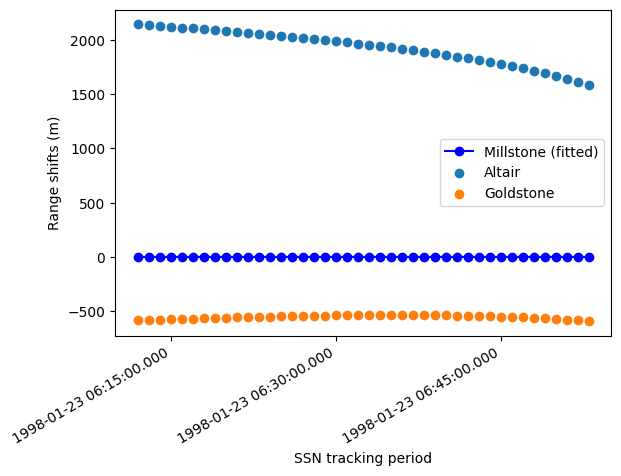

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.plot(ssn_epochs, millstone_shifts, 'bo-', label="Millstone (fitted)")
    plt.scatter(ssn_epochs, altair_shifts, label="Altair")
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for e in ssn_epochs:
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitter.ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitter.ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitter.ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

The Doppler residuals are similar, and of similar magnitude, to those obtained with [hypothesized Altair range data](near_sim_ssn_revfit_altair.ipynb), so the improvement in range fit remains worth pursuing.

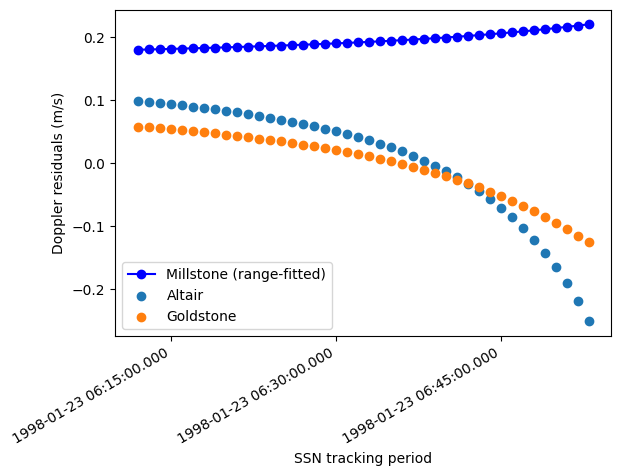

In [12]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.plot(ssn_epochs, millstone_doppler, 'bo-', label="Millstone (range-fitted)")
    plt.scatter(ssn_epochs, altair_doppler, label="Altair")
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()